In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True) #SHOULDN'T NEED THIS ANYMORE -- but just for safety
plt.style.use('/Users/juan/phd/matplotlib/jdefault.mplstyle')
from astropy.stats import histogram
#need to get rid of
import numpy as np
# project
from dynamicAll import models,sampler

# Generating Mock data sets

There are two cases we consider when generating mock data sets:
1. The case in which the stars are drawn from a self-consistent distribution function (DF).
2. The case in which their is a distribution of massless tracers (e.g. stars) embedded in a dark matter potential

In the first case, we either know the DF for the system or density profile for the stars or the potential.
We'll use a self-consistent Plummer sphere DF as an example.

This will be useful case since all of the quantities that we're interested in have analytical expressions.

The distribution function for a Plummer sphere is given by:
$$
f(\mathcal{E}) =
\begin{cases} \frac{24\sqrt{2}}{7\pi^3}
\frac{a^2}{G^5 M^4}(\mathcal{E})^{7/2} & (\mathcal{E}>0) \\ 0 & (\mathcal{E} \leq 0)\end{cases}
$$

In [10]:
model_params = {
    'M' : 1e5,
    'a': 0.5
}
model = models.Plummer(**model_params)
# or:

# model = models.Plummer(model_params['M'],model_params['a'])
# or:
# model = models.plummer(1e5,0.5)

In [11]:
samples= model.sample_w_conditional(N=10_000,save=False)

In [12]:
x  = samples[:,0]
y  = samples[:,1]
z  = samples[:,2]
vx = samples[:,3]
vy = samples[:,4]
vz = samples[:,5]
r  = np.sqrt(x**2 + y**2 + z**2)
vr = (x*vx + y*vy + z*vz)/r
v = np.sqrt(vx**2 + vy**2 + vz**2)

In [13]:
# for checking purposes
def g_q(q):
    '''
    Probability distribution for q = v/v_esc.

    Parameters
    ----------
    q : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    '''
    return q**2*(1-q**2)**(7/2)* (512/(7*np.pi))

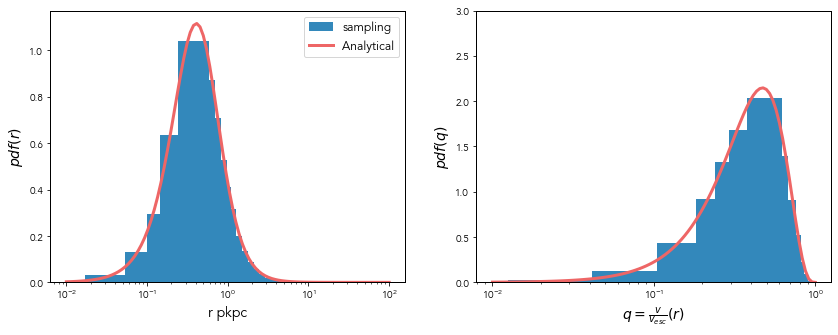

In [14]:
fig,ax = plt.subplots(ncols=2,figsize=(14,5))
r_test = np.logspace(-2,2,100)
N,bin_edges = histogram(r,bins='blocks')
r_center = (bin_edges[1:] + bin_edges[:-1])/2
q = v/model.v_esc(r)
# sanity checks
N,vel_edges = histogram(q,bins='blocks')
q_test = np.logspace(-2,0,100)


ax[0].hist(r,bins=bin_edges,density='True',label='sampling')
ax[0].plot(r_test,model.probability(r_test),label='Analytical')
ax[0].set(
    xscale = 'log',
    xlabel = 'r pkpc',
    ylabel =r'$pdf(r)$' 
)



ax[1].hist(q,bins=vel_edges,density=True);
ax[1].plot(q_test,g_q(q_test))
ax[1].set(
    xscale='log',
    ylim = (0,3),
    xlabel=r'$q =\frac{v}{v_{esc}}(r)$',
    ylabel=r'$pdf(q)$'
)
ax[0].legend()

## Now the same thing with a more general sampler that samples from $\vec{w}$ all at once
Given any non-multimodal distribution function we can sample from it using the well known package emcee.
Assuming you trust the default values we provide, once you've defined the model as above, the sample_w function is all you need to sample from the distribution function.

what acceptance fraction should we have in o

In [9]:
test_samples = model.sample_w(N=10_000)

/opt/homebrew/Caskroom/miniforge/base/envs/py10/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mean acceptance fraction: 0.476
Mean autocorrelation time: 88.040 steps


This will generallly take longer than the conditional sampling, part of that is that by default, it will return 32 chains of N samples -- that can be changed by passing the nwalkers argument to sample_w.

Below we compare the results of the two methods by looking at the predicted velocity dispersion profile.

In neither case does the sampler know about the velocity dispersion so it seems like a good test of the samplers. 
You should also look at the mean acceptance fraction and mean autocorrelation time to make sure the sampler is working "well."

In [26]:
x = test_samples[:,0]
y = test_samples[:,1]
z = test_samples[:,2]
vx = test_samples[:,3]
vy = test_samples[:,4]
vz = test_samples[:,5]
r_test = np.sqrt(x**2 + y**2 + z**2)
vr_test = (x*vx + y*vy + z*vz)/r_test

In [27]:
test_samples.shape,r_test.shape,vr_test.shape

((320000, 6), (320000,), (320000,))

## compare velocity dispersions

In [28]:
from astropy.stats import histogram
from scipy.stats import binned_statistic
meanv,_,bin_numbers  = binned_statistic(r,vr,'mean',bins=bin_edges)
mu,_,bin_numbers   = binned_statistic(r,vr**2,'mean',bins=bin_edges)

In [29]:
meanv2,_,bin_numbers = binned_statistic(r_test,vr_test,'mean',bins=bin_edges)
mu2,_,bin_numbers    = binned_statistic(r_test,vr_test**2,'mean',bins=bin_edges)

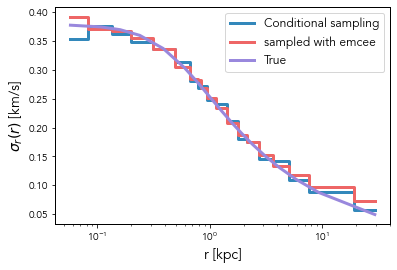

In [30]:
def dispersion(r,M,a):
    G = 4.300917270036279e-06 #kpc km^2 s^-2 Msun^-1
    return G*M/(6*np.sqrt(r**2 + a**2))

fig,ax = plt.subplots()
ax.step(r_center,np.sqrt(mu- meanv**2),
        where = 'mid',
        label = 'Conditional sampling'
        )
ax.step(r_center,np.sqrt(mu2- meanv2**2),
        where = 'mid',
        label = 'sampled with emcee'
        )
ax.plot(r_center,np.sqrt(dispersion(r_center,model._M,model._a)),
        label='True')
ax.set(
    xscale='log',
    xlabel = 'r [kpc]',
    ylabel =r'$\sigma_r(r)$ [km/s]',
    # ylim = (0,1),
)
ax.legend()


It seems like we got a good match between the two methods.
there will always be some differences due to counting, and unlucky rng draws, but the two methods should be consistent.
The emcee sampler should better fit the true curve since its using n_chains*n_steps draws so it'll be more stable than the conditional sampler. 

However if we sample from the samples -- which we can do with just a by drawing uniformly from the flat-chain, we can get smaller subsamples
Drawing randomly from these is a quicker way to generate smaller sub-samples

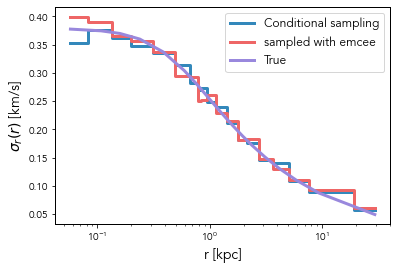

In [42]:
x = np.random.randint(0,320_000,10_000)
meanv2,_,bin_numbers = binned_statistic(r_test[x],vr_test[x],'mean',bins=bin_edges)
mu2,_,bin_numbers    = binned_statistic(r_test[x],vr_test[x]**2,'mean',bins=bin_edges)


fig,ax = plt.subplots()
ax.step(r_center,np.sqrt(mu- meanv**2),
        where = 'mid',
        label = 'Conditional sampling'
        )
ax.step(r_center,np.sqrt(mu2- meanv2**2),
        where = 'mid',
        label = 'sampled with emcee'
        )
ax.plot(r_center,np.sqrt(dispersion(r_center,model._M,model._a)),
        label='True')
ax.set(
    xscale='log',
    xlabel = 'r [kpc]',
    ylabel =r'$\sigma_r(r)$ [km/s]',
    # ylim = (0,1),
)
ax.legend()